In [77]:
!pip install scikit-optimize

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 100 kB 558 kB/s ta 0:00:01
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
from IPython.core.interactiveshell import InteractiveShell
import random
InteractiveShell.ast_node_interactivity = "all"
import os
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import glob
from tqdm import tqdm

from sklearn.preprocessing import LabelEncoder

#classes for grid search and cross-validation, function for splitting data and evaluating models
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV,train_test_split
from skopt import BayesSearchCV
from sklearn.metrics import accuracy_score,f1_score,roc_auc_score,confusion_matrix,roc_curve

#XGBoost library
import xgboost as xgb

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 200

#creating deepcopy of model instances
from copy import deepcopy

In [3]:
df = pd.read_csv('../Data/train.csv')
df.shape

(3577, 10)

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='i', ylabel='count'>

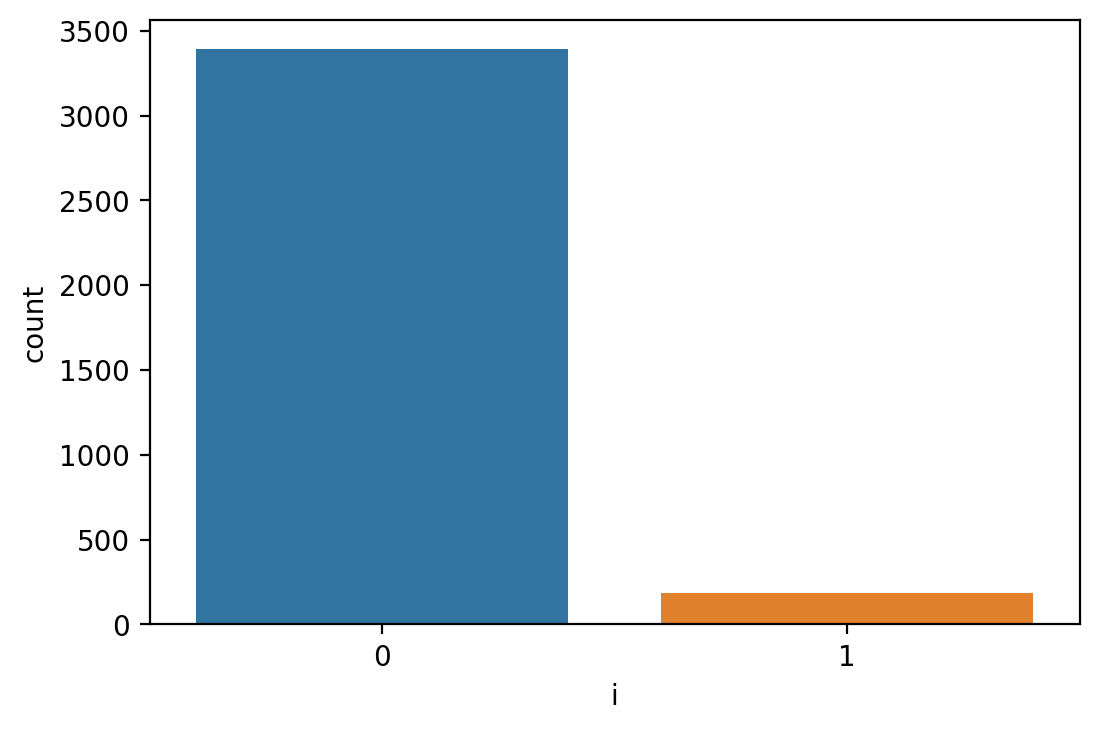

,id,a,b,c,d,e,f,g,h,i
14,74,White,52.0,0,0,fluid,96.59,26.4,Good,1
24,148,White,57.0,1,0,fluid,67.41,32.9,Good,1
40,226,White,81.0,0,0,fluid,184.40,27.5,Good,1
46,177,Black,78.0,1,0,fluid,56.11,25.5,Normal,1
53,106,White,50.0,1,0,fluid,73.18,30.3,Normal,1
...,...,...,...,...,...,...,...,...,...,...
3514,31,Black,42.0,0,0,fluid,83.41,25.4,Unknown,1
3518,72,White,66.0,1,0,fluid,116.55,31.1,Normal,1
3529,68,Black,59.0,0,0,solid,86.23,30.0,Normal,1
3538,63,White,45.0,0,0,fluid,93.72,30.2,Normal,1


,id,a,b,c,d,e,f,g,h,i
0,4453,Black,71.0,1,0,fluid,229.73,30.4,Good,0
1,1473,Black,49.0,1,0,solid,139.43,40.2,Normal,0
2,2119,Black,42.0,0,0,solid,68.24,33.1,Normal,0
3,3391,White,53.0,1,0,solid,240.86,31.9,Good,0
4,1000,Black,70.0,1,0,fluid,74.04,29.1,Good,0
...,...,...,...,...,...,...,...,...,...,...
3572,1402,Black,57.0,0,0,fluid,85.99,21.2,Unknown,0
3573,2927,Black,15.0,0,0,solid,113.28,23.7,Good,0
3574,4937,White,62.0,1,0,solid,103.69,35.2,Worse,0
3575,3001,Black,33.0,0,0,fluid,91.53,38.8,Normal,0


In [4]:
sns.countplot(df["i"],orient="V")
plt.show()

class1 = df[df['i'] == 1]
class0 = df[df['i'] == 0]

class1
class0

In [5]:
!pip install imblearn

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [24]:
def encoding(df):
	# creating instance of labelencoder
	labelencoder = LabelEncoder()

	df['a_'] = labelencoder.fit_transform(df['a'])
	df['e_'] = labelencoder.fit_transform(df['e'])
	df['h_'] = labelencoder.fit_transform(df['h'])
	
	X = df[['a_','b','c','d','e_','f','g','h_','i']].copy()
	
	return X

In [7]:
x= encoding()
x

,a_,b,c,d,e_,f,g,h_,i
0,0,71.0,1,0,0,229.73,30.4,0,0
1,0,49.0,1,0,1,139.43,40.2,1,0
2,0,42.0,0,0,1,68.24,33.1,1,0
3,2,53.0,1,0,1,240.86,31.9,0,0
4,0,70.0,1,0,0,74.04,29.1,0,0
...,...,...,...,...,...,...,...,...,...
3572,0,57.0,0,0,0,85.99,21.2,2,0
3573,0,15.0,0,0,1,113.28,23.7,0,0
3574,2,62.0,1,0,1,103.69,35.2,3,0
3575,0,33.0,0,0,0,91.53,38.8,1,0


In [8]:
x.i.value_counts() / len(x) * 100

0    94.800112
1     5.199888
Name: i, dtype: float64

In [9]:
x.isnull().sum() / len(x) * 100

a_    0.000000
b     0.000000
c     0.000000
d     0.000000
e_    0.000000
f     0.000000
g     4.053676
h_    0.000000
i     0.000000
dtype: float64

In [10]:
# filling null values uisng mean value
x['g'] = x['g'].fillna(x['g'].mean())
x

,a_,b,c,d,e_,f,g,h_,i
0,0,71.0,1,0,0,229.73,30.4,0,0
1,0,49.0,1,0,1,139.43,40.2,1,0
2,0,42.0,0,0,1,68.24,33.1,1,0
3,2,53.0,1,0,1,240.86,31.9,0,0
4,0,70.0,1,0,0,74.04,29.1,0,0
...,...,...,...,...,...,...,...,...,...
3572,0,57.0,0,0,0,85.99,21.2,2,0
3573,0,15.0,0,0,1,113.28,23.7,0,0
3574,2,62.0,1,0,1,103.69,35.2,3,0
3575,0,33.0,0,0,0,91.53,38.8,1,0


In [11]:
x.isnull().sum() / len(x) * 100

a_    0.0
b     0.0
c     0.0
d     0.0
e_    0.0
f     0.0
g     0.0
h_    0.0
i     0.0
dtype: float64

In [12]:
X = x.drop(columns = ['i'])
Y = x[['i']]
X
Y

,a_,b,c,d,e_,f,g,h_
0,0,71.0,1,0,0,229.73,30.4,0
1,0,49.0,1,0,1,139.43,40.2,1
2,0,42.0,0,0,1,68.24,33.1,1
3,2,53.0,1,0,1,240.86,31.9,0
4,0,70.0,1,0,0,74.04,29.1,0
...,...,...,...,...,...,...,...,...
3572,0,57.0,0,0,0,85.99,21.2,2
3573,0,15.0,0,0,1,113.28,23.7,0
3574,2,62.0,1,0,1,103.69,35.2,3
3575,0,33.0,0,0,0,91.53,38.8,1


,i
0,0
1,0
2,0
3,0
4,0
...,...
3572,0
3573,0
3574,0
3575,0


In [13]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3, random_state = 42)

In [14]:
# import SMOTE 
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state = 25, sampling_strategy = 1.0)   # again we are eqalizing both the classes

In [15]:
# fit the sampling
X_train, Y_train = sm.fit_resample(X_train, Y_train)

In [16]:

np.unique(Y_train, return_counts=True)

(array([0, 1]), array([2385, 2385]))

Y_train.i.value_counts()

In [17]:
Y_train.i.value_counts()

0    2385
1    2385
Name: i, dtype: int64

In [19]:
results_dict = {}

#obtaining default parameters by calling .fit() to XGBoost model instance
xgbc0 = xgb.XGBClassifier(objective='binary:logistic',
                          booster='gbtree',
                          eval_metric='auc',
                          tree_method='hist',
                          grow_policy='lossguide',
                          use_label_encoder=False)
xgbc0.fit(X_train , Y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='auc',
              gamma=0, gpu_id=-1, grow_policy='lossguide',
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=12, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='hist', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [21]:
test_predictions = xgbc0.predict(X_test)
accs_test = accuracy_score(Y_test, test_predictions)

accs_test


0.88268156424581

In [22]:
train_predictions = xgbc0.predict(X_train)
accs_train = accuracy_score(Y_train, train_predictions)

accs_train

0.9979035639412998

In [23]:
prediction = pd.read_csv('../Data/test.csv')

In [26]:
def encoding(df):
	# creating instance of labelencoder
	labelencoder = LabelEncoder()

	df['a_'] = labelencoder.fit_transform(df['a'])
	df['e_'] = labelencoder.fit_transform(df['e'])
	df['h_'] = labelencoder.fit_transform(df['h'])
	
	X = df[['a_','b','c','d','e_','f','g','h_']].copy()
	
	return X

In [27]:
pred_X = encoding(prediction)

In [28]:
predict_values =  xgbc0.predict(pred_X)
predict_values.sum()

404

In [29]:
Id = prediction['id']
i = predict_values
res = pd.DataFrame({'Id':Id,'i':i})
type (res)
res.to_csv("../Predictions/xgb_v2.csv",index=False)

pandas.core.frame.DataFrame

<Figure size 4000x3000 with 0 Axes>

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

<Figure size 4000x3000 with 0 Axes>

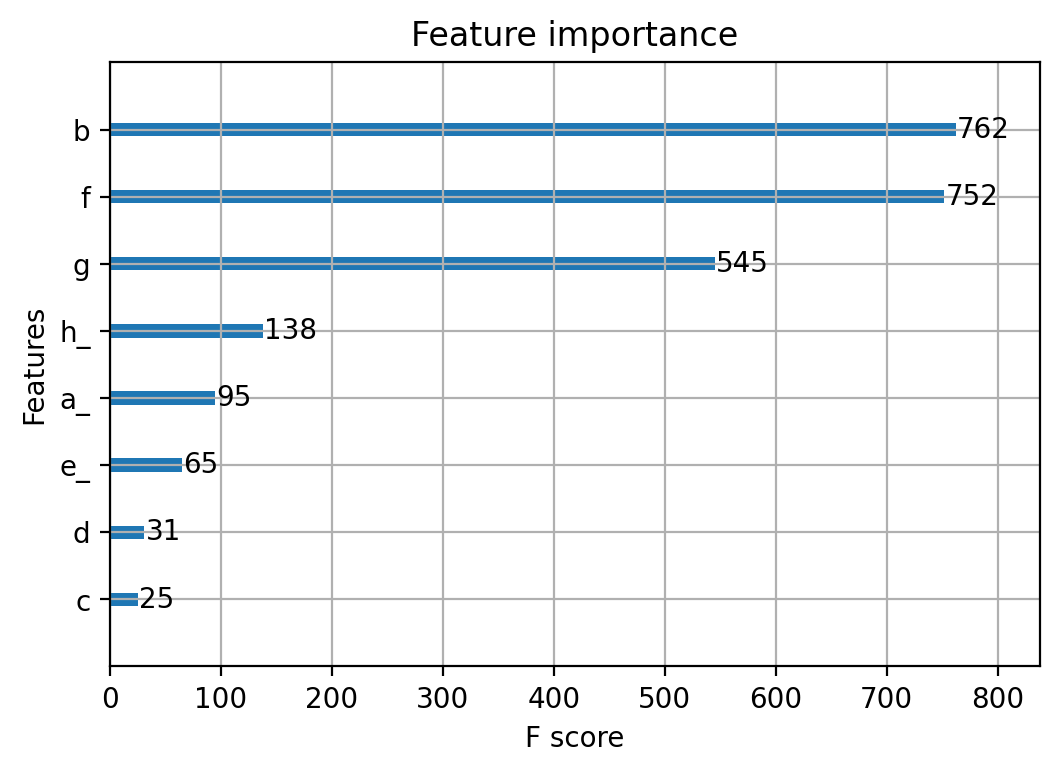

In [30]:
from xgboost import plot_importance
from matplotlib  import pyplot

plt.figure(figsize=(20,15))
plot_importance(xgbc0)
pyplot.show()

<AxesSubplot:>

<AxesSubplot:>

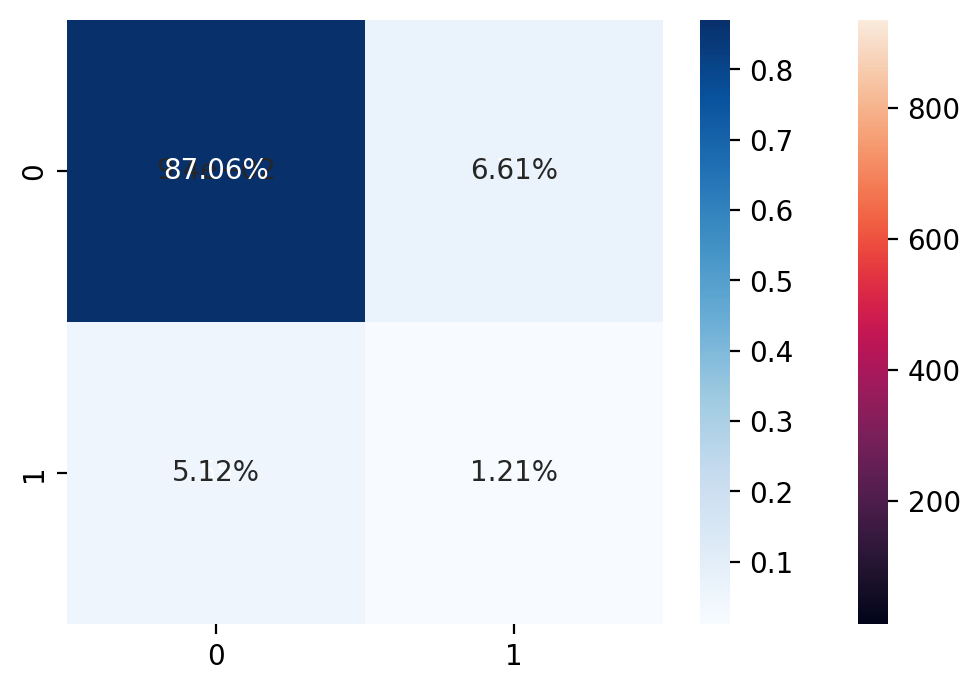

In [34]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(Y_test, test_predictions)
sns.heatmap(cf_matrix, annot=True)

sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')


In [33]:
df.nunique()

id    3577
a        3
b      104
c        2
d        2
e        2
f     2971
g      396
h        4
i        2
dtype: int64

In [34]:
df.info

<bound method DataFrame.info of         id      a     b  c  d      e       f     g        h  i
0     4453  Black  71.0  1  0  fluid  229.73  30.4     Good  0
1     1473  Black  49.0  1  0  solid  139.43  40.2   Normal  0
2     2119  Black  42.0  0  0  solid   68.24  33.1   Normal  0
3     3391  White  53.0  1  0  solid  240.86  31.9     Good  0
4     1000  Black  70.0  1  0  fluid   74.04  29.1     Good  0
...    ...    ...   ... .. ..    ...     ...   ...      ... ..
3572  1402  Black  57.0  0  0  fluid   85.99  21.2  Unknown  0
3573  2927  Black  15.0  0  0  solid  113.28  23.7     Good  0
3574  4937  White  62.0  1  0  solid  103.69  35.2    Worse  0
3575  3001  Black  33.0  0  0  fluid   91.53  38.8   Normal  0
3576  1387  White  37.0  0  0  fluid   98.12  27.5     Good  0

[3577 rows x 10 columns]>

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3577 entries, 0 to 3576
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      3577 non-null   int64  
 1   a       3577 non-null   object 
 2   b       3577 non-null   float64
 3   c       3577 non-null   int64  
 4   d       3577 non-null   int64  
 5   e       3577 non-null   object 
 6   f       3577 non-null   float64
 7   g       3432 non-null   float64
 8   h       3577 non-null   object 
 9   i       3577 non-null   int64  
dtypes: float64(3), int64(4), object(3)
memory usage: 279.6+ KB


In [36]:
df.nunique()

id    3577
a        3
b      104
c        2
d        2
e        2
f     2971
g      396
h        4
i        2
dtype: int64

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3577 entries, 0 to 3576
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      3577 non-null   int64  
 1   a       3577 non-null   object 
 2   b       3577 non-null   float64
 3   c       3577 non-null   int64  
 4   d       3577 non-null   int64  
 5   e       3577 non-null   object 
 6   f       3577 non-null   float64
 7   g       3432 non-null   float64
 8   h       3577 non-null   object 
 9   i       3577 non-null   int64  
dtypes: float64(3), int64(4), object(3)
memory usage: 279.6+ KB


In [38]:
# creating instance of labelencoder
labelencoder = LabelEncoder()

df['a_'] = labelencoder.fit_transform(df['a'])
df['e_'] = labelencoder.fit_transform(df['e'])
df['h_'] = labelencoder.fit_transform(df['h'])

In [39]:
df

,id,a,b,c,d,e,f,g,h,i,a_,e_,h_
0,4453,Black,71.0,1,0,fluid,229.73,30.4,Good,0,0,0,0
1,1473,Black,49.0,1,0,solid,139.43,40.2,Normal,0,0,1,1
2,2119,Black,42.0,0,0,solid,68.24,33.1,Normal,0,0,1,1
3,3391,White,53.0,1,0,solid,240.86,31.9,Good,0,2,1,0
4,1000,Black,70.0,1,0,fluid,74.04,29.1,Good,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3572,1402,Black,57.0,0,0,fluid,85.99,21.2,Unknown,0,0,0,2
3573,2927,Black,15.0,0,0,solid,113.28,23.7,Good,0,0,1,0
3574,4937,White,62.0,1,0,solid,103.69,35.2,Worse,0,2,1,3
3575,3001,Black,33.0,0,0,fluid,91.53,38.8,Normal,0,0,0,1


In [40]:
df.isnull()

,id,a,b,c,d,e,f,g,h,i,a_,e_,h_
0,False,False,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3572,False,False,False,False,False,False,False,False,False,False,False,False,False
3573,False,False,False,False,False,False,False,False,False,False,False,False,False
3574,False,False,False,False,False,False,False,False,False,False,False,False,False
3575,False,False,False,False,False,False,False,False,False,False,False,False,False


In [41]:
# drop missing value rows
#df.dropna(axis=0,how='any',inplace=True)

In [42]:
df

,id,a,b,c,d,e,f,g,h,i,a_,e_,h_
0,4453,Black,71.0,1,0,fluid,229.73,30.4,Good,0,0,0,0
1,1473,Black,49.0,1,0,solid,139.43,40.2,Normal,0,0,1,1
2,2119,Black,42.0,0,0,solid,68.24,33.1,Normal,0,0,1,1
3,3391,White,53.0,1,0,solid,240.86,31.9,Good,0,2,1,0
4,1000,Black,70.0,1,0,fluid,74.04,29.1,Good,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3572,1402,Black,57.0,0,0,fluid,85.99,21.2,Unknown,0,0,0,2
3573,2927,Black,15.0,0,0,solid,113.28,23.7,Good,0,0,1,0
3574,4937,White,62.0,1,0,solid,103.69,35.2,Worse,0,2,1,3
3575,3001,Black,33.0,0,0,fluid,91.53,38.8,Normal,0,0,0,1


In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3577 entries, 0 to 3576
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      3577 non-null   int64  
 1   a       3577 non-null   object 
 2   b       3577 non-null   float64
 3   c       3577 non-null   int64  
 4   d       3577 non-null   int64  
 5   e       3577 non-null   object 
 6   f       3577 non-null   float64
 7   g       3432 non-null   float64
 8   h       3577 non-null   object 
 9   i       3577 non-null   int64  
 10  a_      3577 non-null   int64  
 11  e_      3577 non-null   int64  
 12  h_      3577 non-null   int64  
dtypes: float64(3), int64(7), object(3)
memory usage: 363.4+ KB


In [83]:
X = df[['a_','b','c','d','e_','f','g','h_']]
Y = df[['i']]
Y
X

,i
0,0
1,0
2,0
3,0
4,0
...,...
3572,0
3573,0
3574,0
3575,0


,a_,b,c,d,e_,f,g,h_
0,0,71.0,1,0,0,229.73,30.4,0
1,0,49.0,1,0,1,139.43,40.2,1
2,0,42.0,0,0,1,68.24,33.1,1
3,2,53.0,1,0,1,240.86,31.9,0
4,0,70.0,1,0,0,74.04,29.1,0
...,...,...,...,...,...,...,...,...
3572,0,57.0,0,0,0,85.99,21.2,2
3573,0,15.0,0,0,1,113.28,23.7,0
3574,2,62.0,1,0,1,103.69,35.2,3
3575,0,33.0,0,0,0,91.53,38.8,1


0       0
1       0
2       0
3       0
4       0
       ..
3572    0
3573    0
3574    0
3575    0
3576    0
Name: i, Length: 3577, dtype: int64

In [86]:
X_train, X_test, Y_train, Y_test =train_test_split(X,Y, test_size=0.2,random_state=50,shuffle=True)

In [87]:
#dictionary for collecting results
results_dict = {}

#obtaining default parameters by calling .fit() to XGBoost model instance
xgbc0 = xgb.XGBClassifier(objective='binary:logistic',
                          booster='gbtree',
                          eval_metric='auc',
                          tree_method='hist',
                          grow_policy='lossguide',
                          use_label_encoder=False)
xgbc0.fit(X_train , y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='auc',
              gamma=0, gpu_id=-1, grow_policy='lossguide',
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=12, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='hist', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [89]:
test_predictions = xgbc0.predict(X_test)

In [90]:
accs_test = accuracy_score(y_test, test_predictions)

In [91]:
accs_test

0.9343575418994413

In [92]:
train_predictions = xgbc0.predict(X_train)

In [93]:
accs_train = accuracy_score(y_train, train_predictions)
accs_train

0.9993009437259699

In [94]:
#extracting default parameters from benchmark model
default_params = {}
gparams = xgbc0.get_params()

In [95]:
#default parameters have to be wrapped in lists - even single values - so GridSearchCV can take them as inputs
for key in gparams.keys():
    gp = gparams[key]
    default_params[key] = [gp]

In [96]:
clf0 = GridSearchCV(estimator=xgbc0, scoring='accuracy', param_grid=default_params, return_train_score=True, verbose=1, cv=3)
clf0.fit(X_train, y_train.values.ravel())

Fitting 3 folds for each of 1 candidates, totalling 3 fits


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, eval_metric='auc',
                                     gamma=0, gpu_id=-1,
                                     grow_policy='lossguide',
                                     importance_type='gain',
                                     interaction_constraints='',
                                     learning_rate=0.300000012,
                                     max_delta_step=0, max_depth=6,
                                     min_child_weight=1, missing=nan,
                                     monotone_constraints='...
                         'missing': [nan], 'monotone_constraints': ['()'],
                         'n_estimators': [100], 'n_jobs': [12],
                         'num_parallel_tree': [1],
                         'objective': ['binary:logistic'

In [97]:
#results dataframe
df_r = pd.DataFrame(clf0.cv_results_)

In [98]:
#predictions - inputs to confusion matrix
train_predictions = clf0.predict(X_train)
test_predictions = clf0.predict(X_test)

In [99]:
#confusion matrices
cfm_train = confusion_matrix(y_train, train_predictions)
cfm_test = confusion_matrix(y_test, test_predictions)

In [100]:
#accuracy scores
accs_train = accuracy_score(y_train, train_predictions)
accs_test = accuracy_score(y_test, test_predictions)

accs_train
accs_test

0.9993009437259699

0.9343575418994413

In [101]:
cfm_train
cfm_test

array([[2719,    0],
       [   2,  140]])

array([[664,   8],
       [ 39,   5]])

In [102]:
f1s_train_p1 = f1_score(y_train, train_predictions, pos_label=1)
f1s_train_p0 = f1_score(y_train, train_predictions, pos_label=0)
f1s_test_p1 = f1_score(y_test, test_predictions, pos_label=1)
f1s_test_p0 = f1_score(y_test, test_predictions, pos_label=0)

In [103]:
#Area Under the Receiver Operating Characteristic Curve
test_ras = roc_auc_score(y_test, clf0.predict_proba(X_test)[:,1])

In [104]:
test_ras

0.808103354978355

In [105]:
#best parameters
bp = clf0.best_params_

In [109]:
#storing computed values in results dictionary
results_dict['xgbc0'] = {'iterable_parameter': np.nan,
                         'classifier': deepcopy(clf0),
                         'cv_results': df.copy(),
                         'cfm_train': cfm_train,
                         'cfm_test': cfm_test,
                         'train_accuracy': accs_train,
                         'test_accuracy': accs_test,
                         'train F1-score label 1': f1s_train_p1,
                         'train F1-score label 0': f1s_train_p0,
                         'test F1-score label 1': f1s_test_p1,
                         'test F1-score label 0': f1s_test_p0,
                         
                         'test roc auc score': test_ras,
                        
                         'best_params': bp}

In [110]:
#creating deepcopy of default parameters before manipulations
params = deepcopy(default_params)

#setting grid of selected parameters for iteration
param_grid = {'gamma': [0,0.1,0.2,0.4,0.8,1.6,3.2,6.4,12.8,25.6,51.2,102.4, 200],
              'learning_rate': [0.01, 0.03, 0.06, 0.1, 0.15, 0.2, 0.25, 0.300000012, 0.4, 0.5, 0.6, 0.7],
              'max_depth': [5,6,7,8,9,10,11,12,13,14],
              'n_estimators': [50,65,80,100,115,130,150],
              'reg_alpha': [0,0.1,0.2,0.4,0.8,1.6,3.2,6.4,12.8,25.6,51.2,102.4,200],
              'reg_lambda': [0,0.1,0.2,0.4,0.8,1.6,3.2,6.4,12.8,25.6,51.2,102.4,200]}

In [113]:

#No. of jobs
gcvj = np.cumsum([len(x) for x in param_grid.values()])[-1]

#iteration loop. Each selected parameter iterated separately
for i,grid_key in enumerate(param_grid.keys()):
    
  
       
    #creating param_grid argument for GridSearchCV:
    #listing grid values of current iterable parameter and wrapping non-iterable parameter single values in list
    for param_key in params.keys():
        if param_key == grid_key:
            params[param_key] = param_grid[grid_key]
        else:
            #use best parameters of last iteration
            try:
                param_value = [clf.best_params_[param_key]]
                params[param_key] = param_value
            #use benchmark model parameters for first iteration
            except:
                param_value = [clf0.best_params_[param_key]]
                params[param_key] = param_value
    
    #classifier instance of current iteration
    xgbc = xgb.XGBClassifier(**default_params)
    
    #GridSearch instance of current iteration
    clf = GridSearchCV(estimator=xgbc, param_grid=params, scoring='accuracy', return_train_score=True, verbose=1, cv=3)
    clf.fit(X_train, y_train.values.ravel())
    
    #results dataframe
    df = pd.DataFrame(clf.cv_results_)
    
    #predictions - inputs to confusion matrix
    train_predictions = clf.predict(X_train)
    test_predictions = clf.predict(X_test)
    
    
    #confusion matrices
    cfm_train = confusion_matrix(y_train, train_predictions)
    cfm_test = confusion_matrix(y_test, test_predictions)
    
    #accuracy scores
    accs_train = accuracy_score(y_train, train_predictions)
    accs_test = accuracy_score(y_test, test_predictions)
   
    
    #F1 scores for each train/test label
    f1s_train_p1 = f1_score(y_train, train_predictions, pos_label=1)
    f1s_train_p0 = f1_score(y_train, train_predictions, pos_label=0)
    f1s_test_p1 = f1_score(y_test, test_predictions, pos_label=1)
    f1s_test_p0 = f1_score(y_test, test_predictions, pos_label=0)
    
    
    #Area Under the Receiver Operating Characteristic Curve
    test_ras = roc_auc_score(y_test, clf.predict_proba(X_test)[:,1])
    
    #best parameters
    bp = clf.best_params_
    
    #storing computed values in results dictionary
    results_dict[f'xgbc{i+1}'] = {'iterable_parameter': grid_key,
                                  'classifier': deepcopy(clf),
                                  'cv_results': df.copy(),
                                  'cfm_train': cfm_train,
                                  'cfm_test': cfm_test,
                                  
                                  'train_accuracy': accs_train,
                                  'test_accuracy': accs_test,
                                 
                                  'train F1-score label 1': f1s_train_p1,
                                  'train F1-score label 0': f1s_train_p0,
                                  'test F1-score label 1': f1s_test_p1,
                                  'test F1-score label 0': f1s_test_p0,
                                 
                                  'test roc auc score': test_ras,
                                
                                  'best_params': bp}
    
   


Fitting 3 folds for each of 13 candidates, totalling 39 fits


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=[0.5], booster=['gbtree'],
                                     colsample_bylevel=[1],
                                     colsample_bynode=[1], colsample_bytree=[1],
                                     eval_metric=['auc'], gamma=[0],
                                     gpu_id=[-1], grow_policy=['lossguide'],
                                     importance_type=['gain'],
                                     interaction_constraints=[''],
                                     learning_rate=[0.300000012],
                                     max_delta_step=[0], max_depth=[6],
                                     min_child_weight=[1], miss...
                         'missing': [nan], 'monotone_constraints': ['()'],
                         'n_estimators': [100], 'n_jobs': [12],
                         'num_parallel_tree': [1],
                         'objective': ['binary:logistic'], 'random_state': [0],
              

Fitting 3 folds for each of 12 candidates, totalling 36 fits


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=[0.5], booster=['gbtree'],
                                     colsample_bylevel=[1],
                                     colsample_bynode=[1], colsample_bytree=[1],
                                     eval_metric=['auc'], gamma=[0],
                                     gpu_id=[-1], grow_policy=['lossguide'],
                                     importance_type=['gain'],
                                     interaction_constraints=[''],
                                     learning_rate=[0.300000012],
                                     max_delta_step=[0], max_depth=[6],
                                     min_child_weight=[1], miss...
                         'monotone_constraints': ['()'], 'n_estimators': [100],
                         'n_jobs': [12], 'num_parallel_tree': [1],
                         'objective': ['binary:logistic'], 'random_state': [0],
                         'reg_alpha': [0], 'reg_lambda': 

Fitting 3 folds for each of 10 candidates, totalling 30 fits


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=[0.5], booster=['gbtree'],
                                     colsample_bylevel=[1],
                                     colsample_bynode=[1], colsample_bytree=[1],
                                     eval_metric=['auc'], gamma=[0],
                                     gpu_id=[-1], grow_policy=['lossguide'],
                                     importance_type=['gain'],
                                     interaction_constraints=[''],
                                     learning_rate=[0.300000012],
                                     max_delta_step=[0], max_depth=[6],
                                     min_child_weight=[1], miss...
                         'monotone_constraints': ['()'], 'n_estimators': [100],
                         'n_jobs': [12], 'num_parallel_tree': [1],
                         'objective': ['binary:logistic'], 'random_state': [0],
                         'reg_alpha': [0], 'reg_lambda': 

Fitting 3 folds for each of 7 candidates, totalling 21 fits


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=[0.5], booster=['gbtree'],
                                     colsample_bylevel=[1],
                                     colsample_bynode=[1], colsample_bytree=[1],
                                     eval_metric=['auc'], gamma=[0],
                                     gpu_id=[-1], grow_policy=['lossguide'],
                                     importance_type=['gain'],
                                     interaction_constraints=[''],
                                     learning_rate=[0.300000012],
                                     max_delta_step=[0], max_depth=[6],
                                     min_child_weight=[1], miss...
                         'n_estimators': [50, 65, 80, 100, 115, 130, 150],
                         'n_jobs': [12], 'num_parallel_tree': [1],
                         'objective': ['binary:logistic'], 'random_state': [0],
                         'reg_alpha': [0], 'reg_lambda': [1],


Fitting 3 folds for each of 13 candidates, totalling 39 fits


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=[0.5], booster=['gbtree'],
                                     colsample_bylevel=[1],
                                     colsample_bynode=[1], colsample_bytree=[1],
                                     eval_metric=['auc'], gamma=[0],
                                     gpu_id=[-1], grow_policy=['lossguide'],
                                     importance_type=['gain'],
                                     interaction_constraints=[''],
                                     learning_rate=[0.300000012],
                                     max_delta_step=[0], max_depth=[6],
                                     min_child_weight=[1], miss...
                         'num_parallel_tree': [1],
                         'objective': ['binary:logistic'], 'random_state': [0],
                         'reg_alpha': [0, 0.1, 0.2, 0.4, 0.8, 1.6, 3.2, 6.4,
                                       12.8, 25.6, 51.2, 102.4, 200],
      

Fitting 3 folds for each of 13 candidates, totalling 39 fits


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=[0.5], booster=['gbtree'],
                                     colsample_bylevel=[1],
                                     colsample_bynode=[1], colsample_bytree=[1],
                                     eval_metric=['auc'], gamma=[0],
                                     gpu_id=[-1], grow_policy=['lossguide'],
                                     importance_type=['gain'],
                                     interaction_constraints=[''],
                                     learning_rate=[0.300000012],
                                     max_delta_step=[0], max_depth=[6],
                                     min_child_weight=[1], miss...
                         'num_parallel_tree': [1],
                         'objective': ['binary:logistic'], 'random_state': [0],
                         'reg_alpha': [0],
                         'reg_lambda': [0, 0.1, 0.2, 0.4, 0.8, 1.6, 3.2, 6.4,
                                

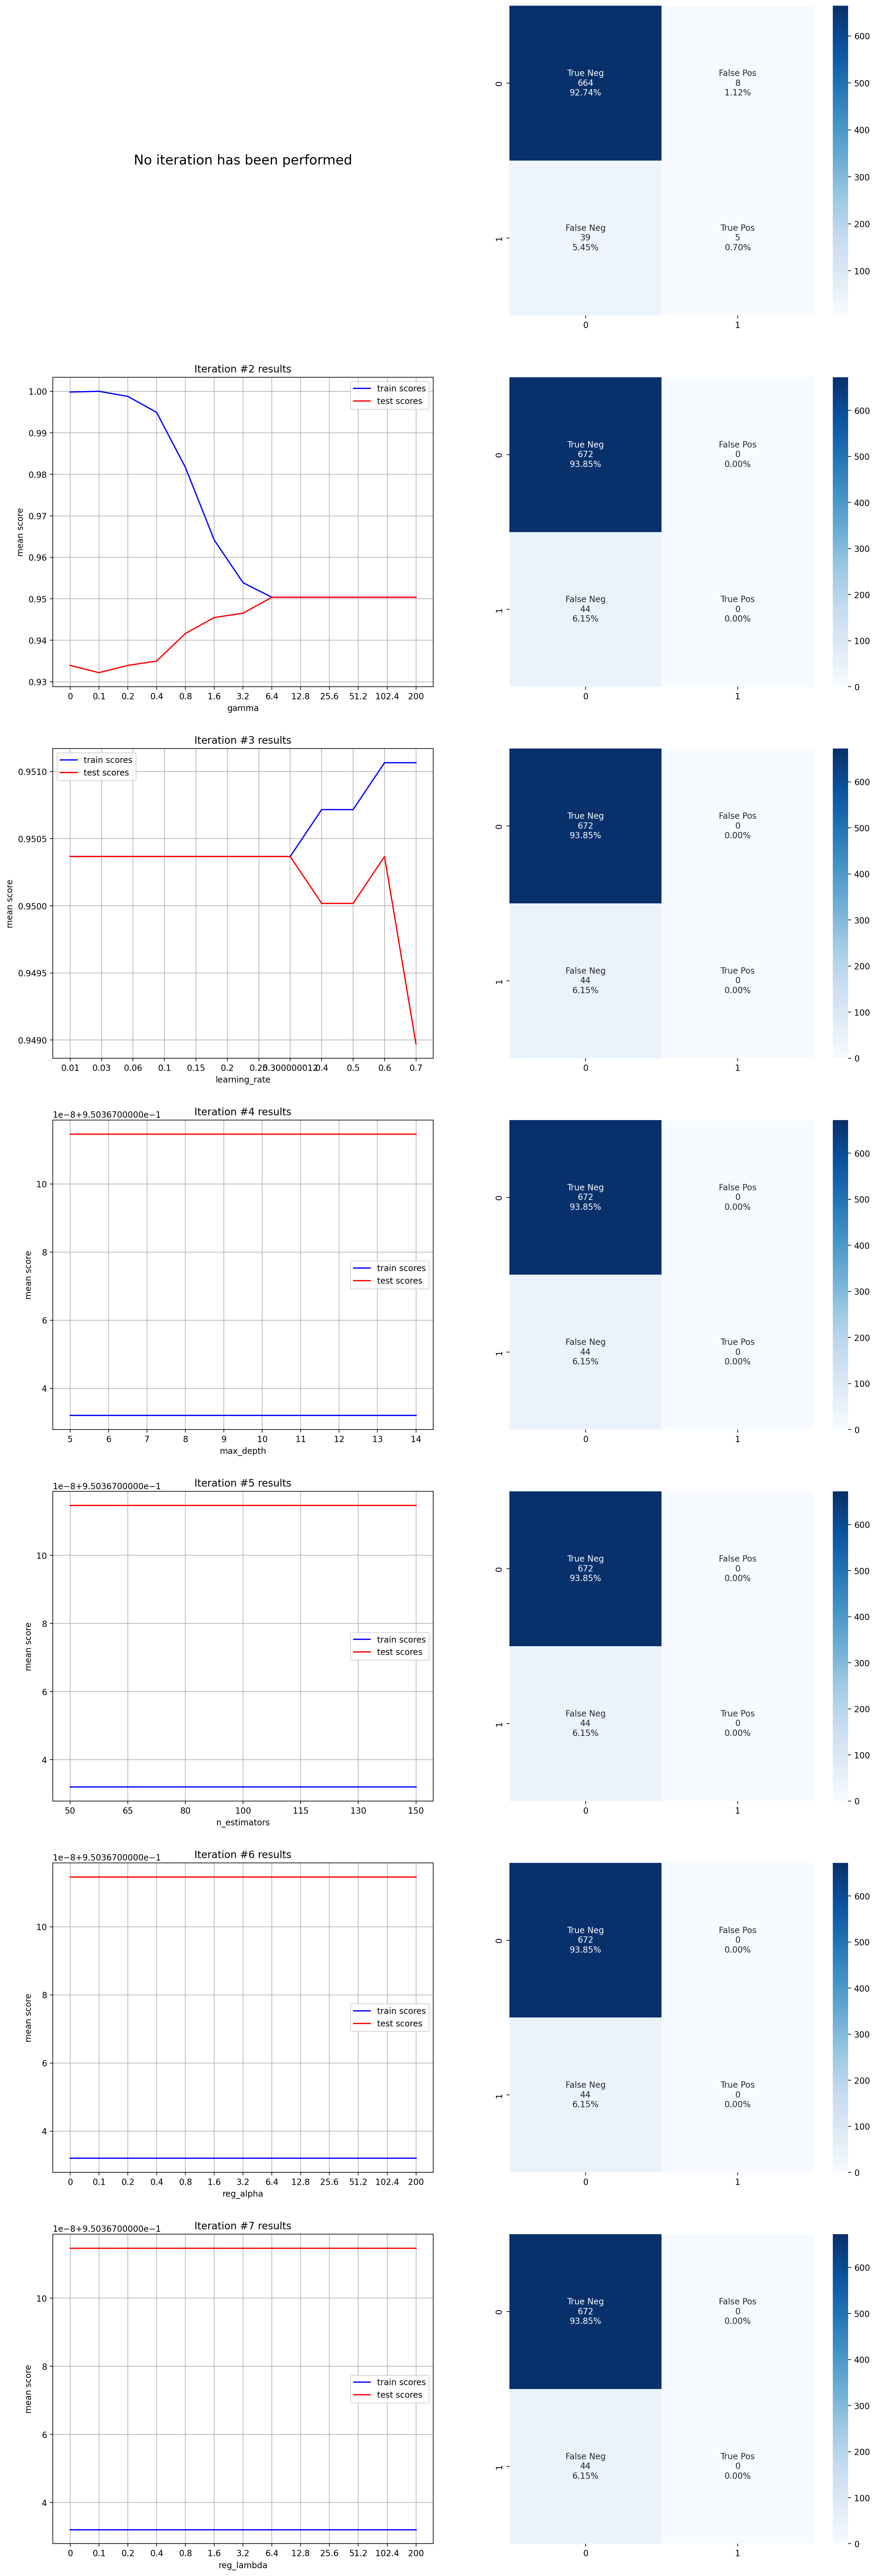

In [116]:
#number of rows depend on number of iterations
nrows = len(results_dict.keys())

#standard group names for confusion matrices
group_names = ['True Neg','False Pos','False Neg','True Pos']

#creating figure
f, axes = plt.subplots(nrows,2,figsize=(18,8*nrows));

#iteratively plotting train/test accuracy scores and test confusion matrix
for i,ax in enumerate(axes):
    
    #current key of results dictionary
    ckey = list(results_dict.keys())[i] 
    
    #plotting scores for models other than the benchark model
    if ckey != 'xgbc0':
        x1 = results_dict[ckey]['cv_results'].loc[:,'mean_train_score']
        x2 = results_dict[ckey]['cv_results'].loc[:,'mean_test_score']
        
        ax[0].plot(x1, label='train scores', color='blue');
        ax[0].plot(x2, label='test scores', color='red');
        ax[0].set_title(f'Iteration #{i+1} results');
               
        ax[0].set_xticks(list(range(0,len([x[results_dict[ckey]['iterable_parameter']] for x in results_dict[ckey]['cv_results']['params']]))));
        ax[0].set_xticklabels(sorted([x[results_dict[ckey]['iterable_parameter']] for x in results_dict[ckey]['cv_results']['params']]));
    
        ax[0].grid('major');
        ax[0].legend();
        ax[0].set_xlabel(results_dict[ckey]['iterable_parameter'])
        ax[0].set_ylabel('mean score');
    
    #leaving scores plot blank for benchmark model
    else:
        ax[0].axis('off')
        ax[0].text(x=0.5, y=0.5, s='No iteration has been performed', fontsize=16, va='center', ha='center')
    
    #computing variables for specific confusion matrix
    group_counts = ["{0:0.0f}".format(value) for value in results_dict[ckey]['cfm_test'].flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in results_dict[ckey]['cfm_test'].flatten()/np.sum(results_dict[ckey]['cfm_test'])]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    
    #plotting confusion matrix
    sns.heatmap(results_dict[ckey]['cfm_test'], annot=labels, fmt='', cmap='Blues', ax=ax[1])
    
plt.show();

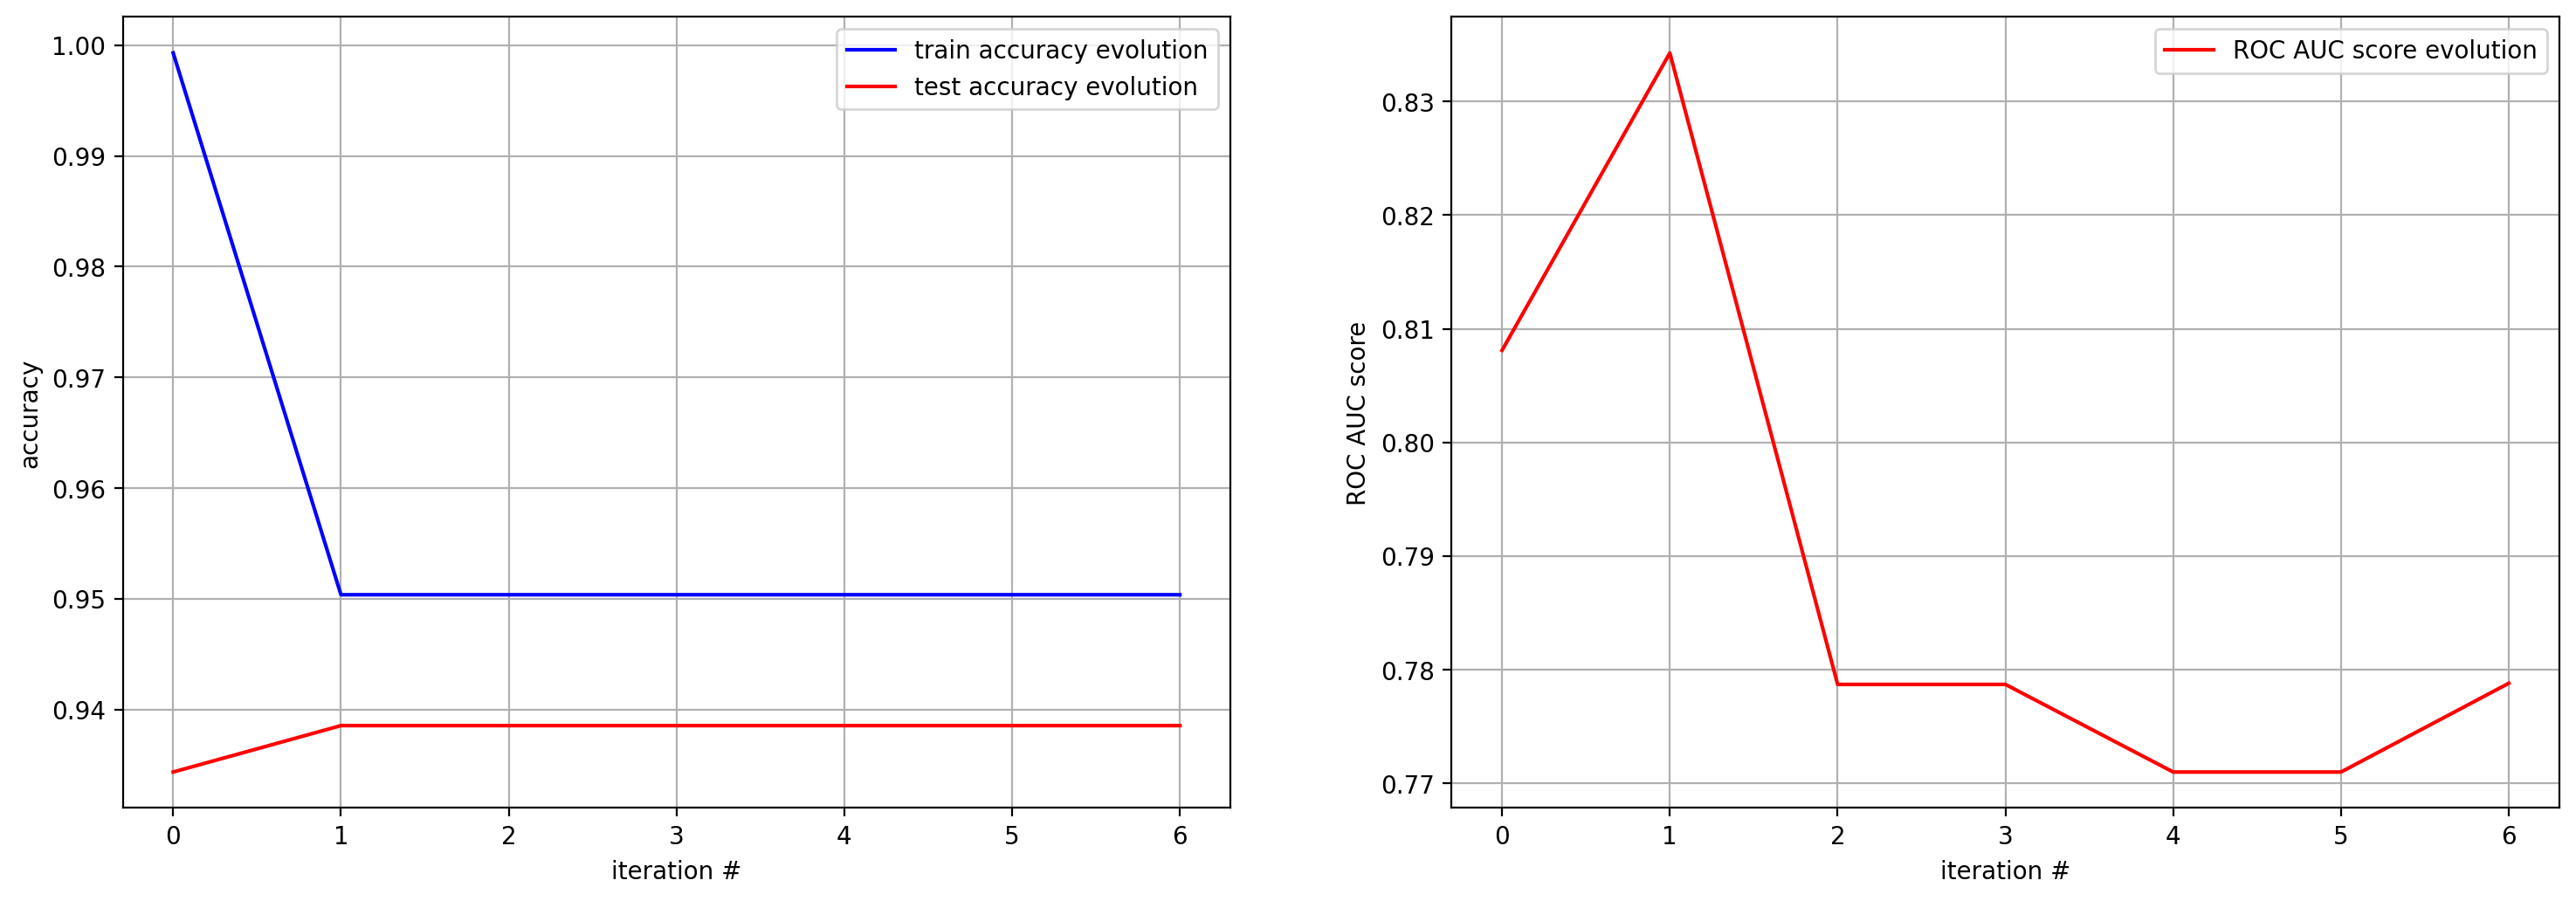

In [117]:
f, axes = plt.subplots(1,2,figsize=(18,6));

#plotting evolution of train/test accuracy scores for subsequent iterations
axes[0].plot([results_dict[key]['train_accuracy'] for key in results_dict.keys()], label='train accuracy evolution', color='blue');
axes[0].plot([results_dict[key]['test_accuracy'] for key in results_dict.keys()], label='test accuracy evolution', color='red');

#setting labels, drawing legend and major grid
axes[0].set_xlabel('iteration #');
axes[0].set_ylabel('accuracy');
axes[0].legend();
axes[0].grid('major');

#plotting evolution of test ROC AUC scores for subsequent iterations
axes[1].plot([results_dict[key]['test roc auc score'] for key in results_dict.keys()], label='ROC AUC score evolution', color='red');

#setting labels, drawing legend and major grid
axes[1].set_xlabel('iteration #');
axes[1].set_ylabel('ROC AUC score');
axes[1].legend();
axes[1].grid('major');

plt.show();

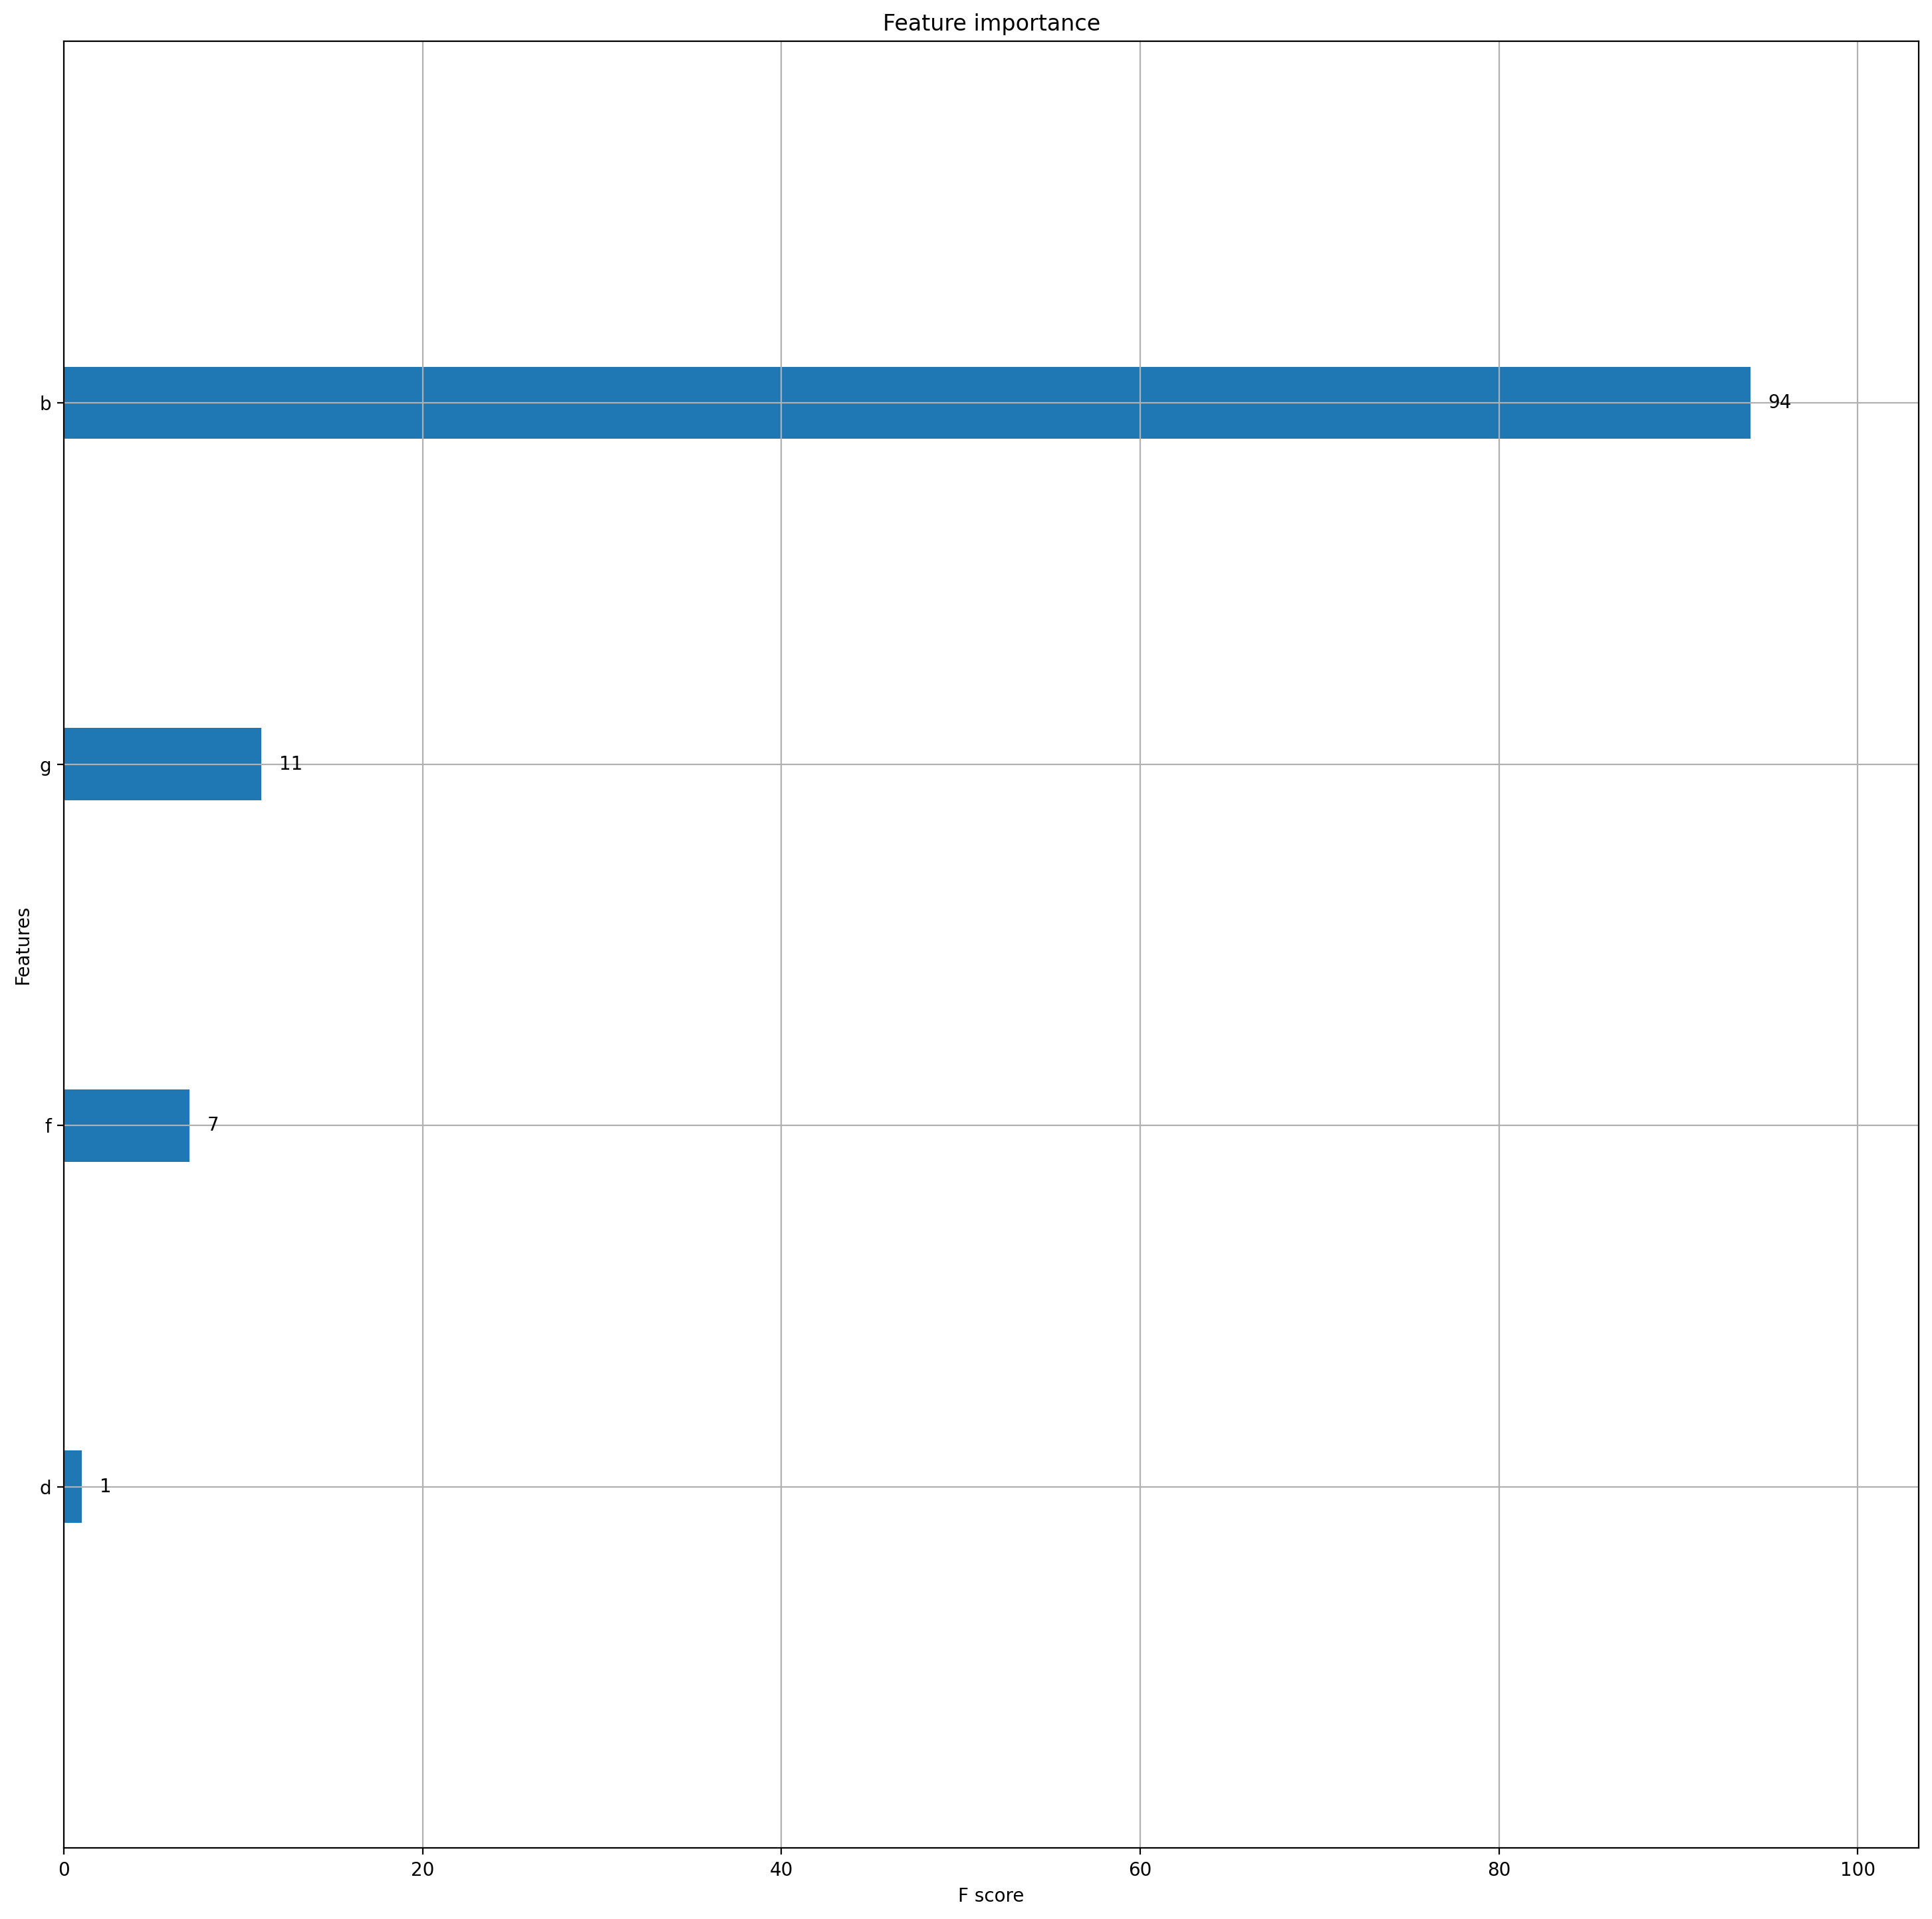

In [118]:
#plotting feature importance
f, ax = plt.subplots(figsize=(18,18));
xgb.plot_importance(clf.best_estimator_, ax=ax);

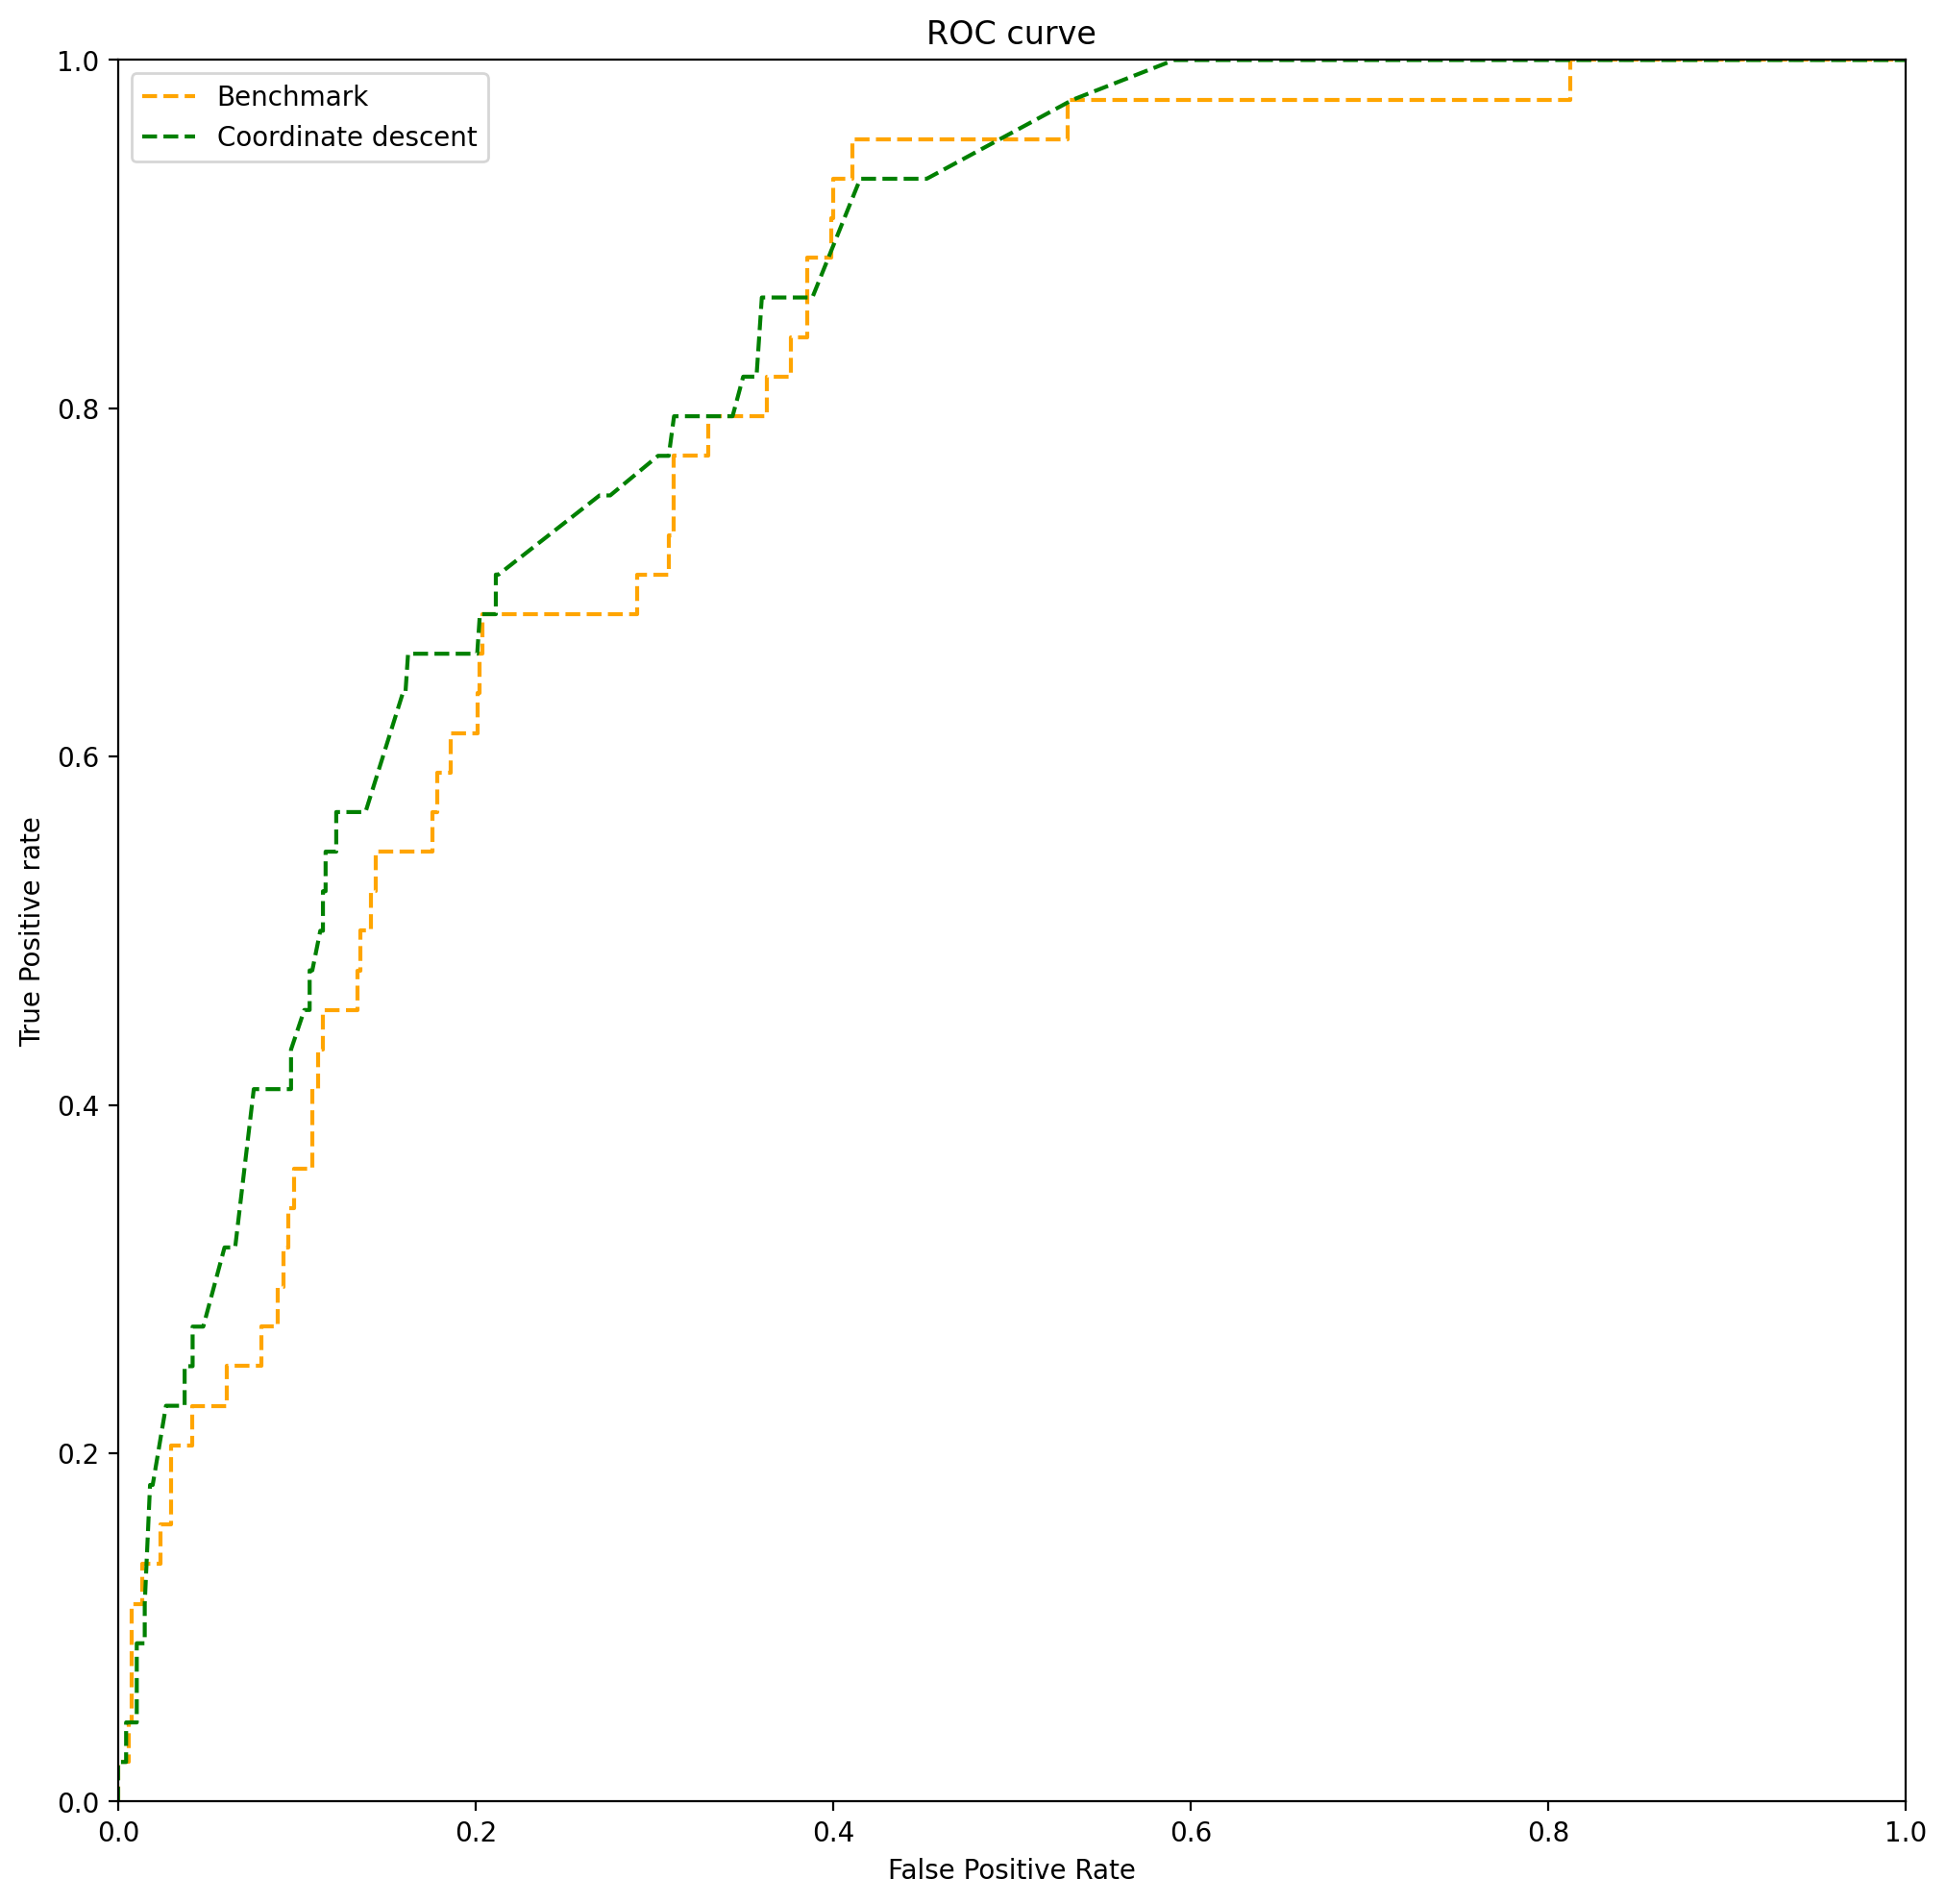

In [121]:
fpr_bm, tpr_bm, thresh_bm = roc_curve(y_test, clf0.predict_proba(X_test)[:,1], pos_label=1)
fpr_cd, tpr_cd, thresh_cd = roc_curve(y_test, results_dict['xgbc1']['classifier'].predict_proba(X_test)[:,1], pos_label=1)

# roc curve for tpr = fpr 
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)

#plotting roc curves
plt.figure(figsize=(12,12));
plt.plot(fpr_bm, tpr_bm, linestyle='--',color='orange', label='Benchmark');
plt.plot(fpr_cd, tpr_cd, linestyle='--',color='green', label='Coordinate descent');

plt.xlim((0,1));
plt.ylim((0,1));

plt.title('ROC curve');
plt.xlabel('False Positive Rate');
plt.ylabel('True Positive rate');

plt.legend(loc='best');
plt.show();

In [123]:
xgbc1 = results_dict['xgbc1']
test_predictions = xgbc1.predict(X_test)
accs_test = accuracy_score(y_test, test_predictions)
accs_test

AttributeError: 'dict' object has no attribute 'predict'

In [124]:
xgbc1 = results_dict['xgbc1']

In [125]:
xgbc1

{'iterable_parameter': 'gamma',
 'classifier': GridSearchCV(cv=3,
              estimator=XGBClassifier(base_score=[0.5], booster=['gbtree'],
                                      colsample_bylevel=[1],
                                      colsample_bynode=[1], colsample_bytree=[1],
                                      eval_metric=['auc'], gamma=[0],
                                      gpu_id=[-1], grow_policy=['lossguide'],
                                      importance_type=['gain'],
                                      interaction_constraints=[''],
                                      learning_rate=[0.300000012],
                                      max_delta_step=[0], max_depth=[6],
                                      min_child_weight=[1], miss...
                          'missing': [nan], 'monotone_constraints': ['()'],
                          'n_estimators': [100], 'n_jobs': [12],
                          'num_parallel_tree': [1],
                          'objecti

In [126]:
df_bestparams = pd.DataFrame([{key: clf0.best_params_[key] for key in param_grid.keys()},
                              {key: results_dict['xgbc1']['classifier'].best_params_[key] for key in param_grid.keys()},
                              {key: results_dict['xgbc2']['classifier'].best_params_[key] for key in param_grid.keys()},
                              {key: results_dict['xgbc3']['classifier'].best_params_[key] for key in param_grid.keys()}],
                              index=['Benchmark', 'xgbc1', 'xgbc2', 'xgbc3'])
df_bestparams

,gamma,learning_rate,max_depth,n_estimators,reg_alpha,reg_lambda
Benchmark,0.0,0.30,6,100,0,1
xgbc1,6.4,0.30,6,100,0,1
xgbc2,6.4,0.01,6,100,0,1
xgbc3,6.4,0.01,5,100,0,1


In [127]:
space={'max_depth': 6,
        'gamma': 6.4,
        'reg_alpha' : 0,
        'reg_lambda' : 1,
        'n_estimators': 100
    }

In [130]:
from xgboost import XGBClassifier
clf=XGBClassifier(n_estimators =space['n_estimators'], max_depth = int(space['max_depth']), gamma = space['gamma'],
                    reg_alpha = int(space['reg_alpha']),reg_lambda =int(space['reg_lambda']))
    
evaluation = [( x_train, y_train), ( x_test, y_test)]
    
clf.fit(x_train, y_train,eval_set=evaluation, eval_metric="auc",early_stopping_rounds=50,verbose=False)

/usr/local/lib/python3.8/dist-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/due/.local/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/due/.local/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=6.4, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=12, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [155]:
test_predictions = xgbc0.predict(X_test)
accs_test = accuracy_score(Y_test, test_predictions)
accs_test

0.9343575418994413

In [156]:
train_predictions = xgbc0.predict(X_train)
accs_train = accuracy_score(Y_train, train_predictions)
accs_train

0.9993009437259699

<Figure size 4000x3000 with 0 Axes>

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

<Figure size 4000x3000 with 0 Axes>

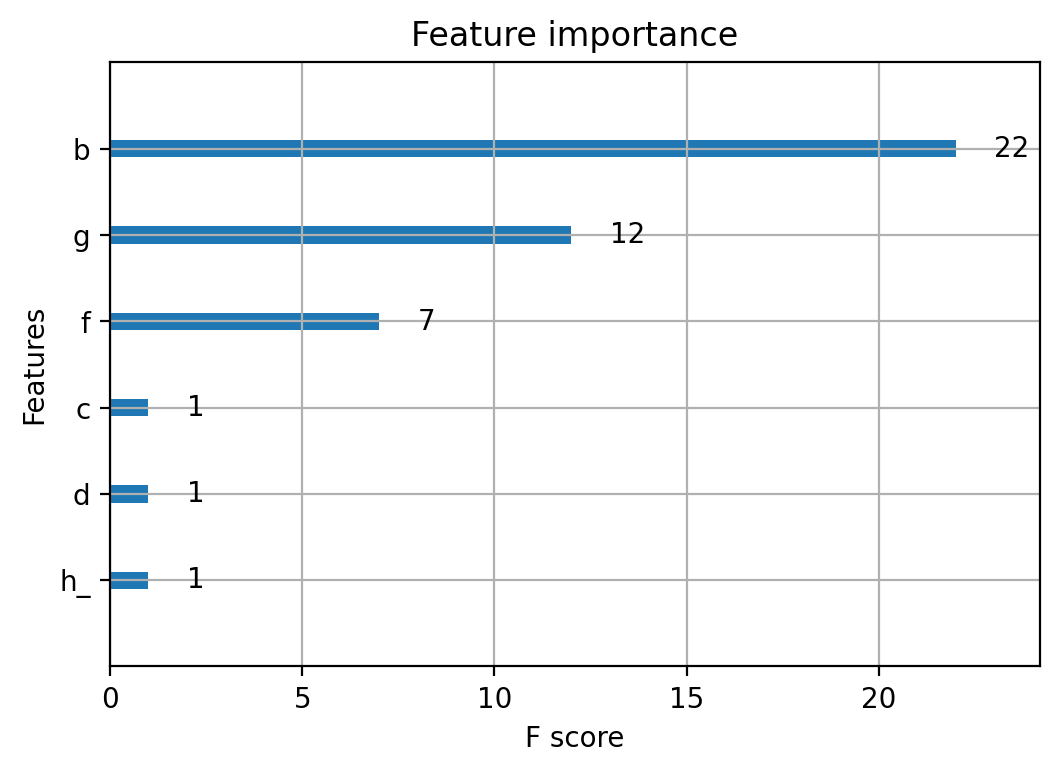

In [136]:
from xgboost import plot_importance
from matplotlib  import pyplot

plt.figure(figsize=(20,15))
plot_importance(clf)
pyplot.show()

In [4]:
# prediction
prediction = pd.read_csv('../Data/test.csv')
prediction.shape

(1533, 9)

In [140]:
prediction['a_'] = labelencoder.fit_transform(prediction['a'])
prediction['e_'] = labelencoder.fit_transform(prediction['e'])
prediction['h_'] = labelencoder.fit_transform(prediction['h'])
prediction

,id,a,b,c,d,e,f,g,h,a_,e_,h_
0,169,Black,81.0,0,0,fluid,91.54,31.4,Good,0,0,0
1,4022,White,81.0,1,0,solid,181.23,36.7,Good,1,1,0
2,4313,Black,57.0,0,0,solid,134.76,29.1,Unknown,0,1,2
3,1052,White,61.0,0,0,fluid,78.65,36.2,Normal,1,0,1
4,1100,White,67.0,0,0,solid,68.61,31.9,Good,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1528,349,White,48.0,0,0,solid,101.41,20.7,Worse,1,1,3
1529,1535,White,55.0,0,0,solid,231.76,42.9,Good,1,1,0
1530,2251,Black,49.0,0,0,solid,130.07,26.0,Good,0,1,0
1531,3801,White,28.0,0,0,solid,69.50,24.5,Good,1,1,0


In [141]:
prediction_X = prediction[['a_','b','c','d','e_','f','g','h_']]

In [142]:
prediction_X

,a_,b,c,d,e_,f,g,h_
0,0,81.0,0,0,0,91.54,31.4,0
1,1,81.0,1,0,1,181.23,36.7,0
2,0,57.0,0,0,1,134.76,29.1,2
3,1,61.0,0,0,0,78.65,36.2,1
4,1,67.0,0,0,1,68.61,31.9,0
...,...,...,...,...,...,...,...,...
1528,1,48.0,0,0,1,101.41,20.7,3
1529,1,55.0,0,0,1,231.76,42.9,0
1530,0,49.0,0,0,1,130.07,26.0,0
1531,1,28.0,0,0,1,69.50,24.5,0


In [157]:
predict_values =  xgbc0.predict(prediction_X)
predict_values.sum()

22

In [159]:

Id = prediction['id']
i = predict_values
res = pd.DataFrame({'Id':Id,'i':i})
type (res)
res.to_csv("../Predictions/predictions.csv",index=False)

pandas.core.frame.DataFrame